# Citi Bike NYC dataset

This notebook analyzes the 2015 Citi Bike NYC system data (rides between bike-sharing stations). Resources:

- <https://www.citibikenyc.com/system-data>
- <http://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/>

In [1]:
%matplotlib inline

In [2]:
import choix
import csv
import datetime
import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle

from thesis.choicerank import displacement, weighted_quantiles, qtod
from scipy.stats import entropy

## Building the graph from the data.

In [3]:
%%time
threshold = datetime.timedelta(hours=1, minutes=0)

graph = nx.DiGraph()
for path in glob.glob("data/citibike/2015*-citibike-tripdata.csv"):
    print(".", end="")
    with open(path) as f:
        reader = csv.DictReader(f)
        for row in reader:
            src = int(row["start station id"])
            dst = int(row["end station id"])
            try:
                start = datetime.datetime.strptime(row["starttime"], "%m/%d/%Y %H:%M:%S")
                stop = datetime.datetime.strptime(row["stoptime"], "%m/%d/%Y %H:%M:%S")
            except:
                # Later files do not have the seconds at the end.
                start = datetime.datetime.strptime(row["starttime"], "%m/%d/%Y %H:%M")
                stop = datetime.datetime.strptime(row["stoptime"], "%m/%d/%Y %H:%M")
            if stop - start < threshold and src != dst:
                if not graph.has_edge(src, dst):
                    graph.add_edge(src, dst, traffic=1.0)
                else:
                    graph.edges[src,dst]["traffic"] += 1.0

# Keep only edges that appear at least once per day on average.
tot_count = 0
for u, v, traffic in list(graph.edges(data="traffic")):
    if traffic < 365:
        graph.remove_edge(u, v)
    else:
        tot_count += traffic
        
# Relabel nodes.
graph = nx.convert_node_labels_to_integers(graph, label_attribute="station_id")
print("done (total traffic: {:,})".format(tot_count))

for v in graph.nodes:
    graph.nodes[v]["in"] = 0
    graph.nodes[v]["out"] = 0

for src, dst, traff in graph.edges(data="traffic"):
    graph.nodes[src]["out"] += traff
    graph.nodes[dst]["in"] += traff

............done (total traffic: 3,380,552.0)
CPU times: user 7min 29s, sys: 2.49 s, total: 7min 32s
Wall time: 7min 32s


In [4]:
inflow = np.array(list(graph.nodes[v]["in"] for v in graph), dtype=float)
outflow = np.array(list(graph.nodes[v]["out"] for v in graph), dtype=float)

In [5]:
print("{:,} nodes, {:,} edges".format(len(graph), len(graph.edges())))
print("inflow: {:,} outflow: {:,}".format(int(inflow.sum()), int(outflow.sum())))

497 nodes, 5,209 edges
inflow: 3,380,552 outflow: 3,380,552


## Estimating transition probabilities

We compare ChoiceRank to three baselines (traffic, pagerank, uniform) against the observed (ground-truth) transition counts.
We use two metrics:

- the KL-divergence
- the average displacement (ranking metric)

Running ChoiceRank.

In [6]:
%%time
# /!\ Beware, `alpha` here corresponds to α - 1 in the thesis.
thetas = choix.choicerank(graph, inflow, outflow, alpha=1.0, tol=1e-08, max_iter=10000)
crs = np.exp(thetas)

CPU times: user 1.2 s, sys: 3.73 ms, total: 1.2 s
Wall time: 1.2 s


Running PageRank.

In [7]:
%%time
pr = nx.pagerank_scipy(graph, weight=None)
prs = np.array(list(pr[v] for v in graph), dtype=float)

CPU times: user 12.4 ms, sys: 1.45 ms, total: 13.8 ms
Wall time: 12.7 ms


Compute accuracy w.r.t. ground-truth.

In [8]:
%%time
methods = ["crnk", "traf", "prnk", "unif"]
kls = {m: list() for m in methods}
dps = {m: list() for m in methods}
ws = list()

for v in list(graph):
    succs = list(graph.successors(v))
    if len(succs) < 2:
        continue
    ps = np.zeros(len(succs))
    qs = {m: np.zeros(len(succs)) for m in methods}
    for i, s in enumerate(succs):
        ps[i] = graph.edges[v,s]["traffic"]
        qs["crnk"][i] = crs[s]
        qs["traf"][i] = graph.nodes[s]["in"]
        qs["prnk"][i] = prs[s]
        qs["unif"][i] = 1.0
    ps = ps / np.sum(ps)
    for m in methods:
        qs[m] = qs[m] / np.sum(qs[m])
        kls[m].append(entropy(ps, qs[m]))
        dps[m].append(displacement(qs[m], ps) / len(succs)**2)
    ws.append(graph.nodes[v]["out"])
print("done.")

done.
CPU times: user 174 ms, sys: 820 µs, total: 174 ms
Wall time: 174 ms


In [9]:
kls = {m: np.array(kls[m]) for m in methods}
dps = {m: np.array(dps[m]) for m in methods}

## Plotting the weighted accuracy

In [10]:
fractions = [0.05, 0.25, 0.5, 0.75, 0.95]
kls2 = dict()
dps2 = dict()

for m in methods:
    kls2[m] = qtod(zip(fractions, weighted_quantiles(kls[m], ws, fractions=fractions)))
    dps2[m] = qtod(zip(fractions, weighted_quantiles(dps[m], ws, fractions=fractions)))

Text(0.5,1,'Displacement')

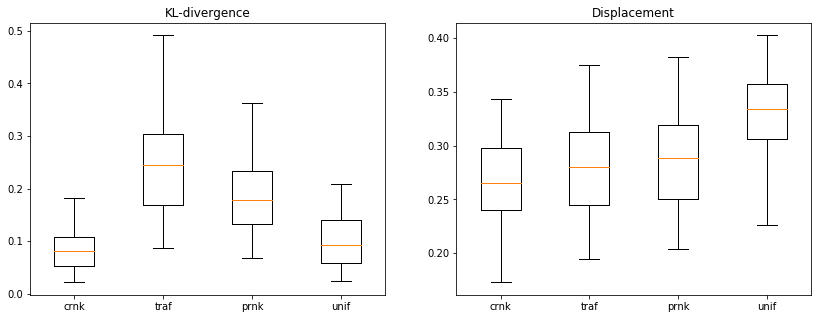

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14.0, 5.0))
# KL-divergence.
axs[0].boxplot(list(kls2[m] for m in methods), labels=methods, whis=[5, 95])
axs[0].set_title("KL-divergence")
# Displacement
axs[1].boxplot(list(dps2[m] for m in methods), labels=methods, whis=[5, 95])
axs[1].set_title("Displacement")

## Save data for further usage

In [12]:
data = {
    "kls": kls,
    "dps": dps,
    "ws": ws,
}
with open("data/citibike-2015.pickle", "wb") as f:
    pickle.dump(data, f)